In [1]:
%matplotlib notebook

import numpy as np
import hyperspy.api as hs
import matplotlib.pyplot as plt

In [2]:
experimental_data = hs.load("SPEDB_bgred.hspy")

In [6]:
experimental_data.plot(vmax=50)

In [243]:
test_patterns = experimental_data.inav[13,65]

In [3]:
test_patterns = hs.signals.Signal2D((experimental_data.inav[13,65].data,
                                     experimental_data.inav[29,65].data,
#                                      experimental_data.inav[13,81].data,
                                     experimental_data.inav[29,103].data,
                                     experimental_data.inav[88,88].data,
                                     experimental_data.inav[95,41].data,
                                     experimental_data.inav[67,121].data,
                                     experimental_data.inav[67,121].data,
                                     experimental_data.inav[64,33].data,
                                     experimental_data.inav[3,116].data,))

In [4]:
test_patterns.set_signal_type('electron_diffraction')

In [5]:
experimental_data.set_signal_type('electron_diffraction')
diffraction_calibration = 0.0096   #guess
experimental_data.set_diffraction_calibration(diffraction_calibration)

In [6]:
from diffsims.generators.rotation_list_generators import get_beam_directions_grid
resolution = 1 
grid = get_beam_directions_grid("cubic", resolution, mesh="spherified_cube_edge")

/home/joseph/miniconda3/envs/pyxemmaster/lib/python3.9/site-packages/diffsims/generators/sphere_mesh_generators.py:515: RuntimeWarning: invalid value encountered in true_divide
  phi2 = sign * np.nan_to_num(np.arccos(x_comp / norm_proj))


In [7]:
import diffpy
from diffsims.libraries.structure_library import StructureLibrary
from diffsims.generators.diffraction_generator import DiffractionGenerator
from diffsims.generators.library_generator import DiffractionLibraryGenerator
from pyxem.utils import indexation_utils as iutls
from pyxem.utils import plotting_utils as putls
from pyxem.utils import polar_transform_utils as ptutls
from pyxem.utils import expt_utils as eutls

In [8]:
# Parameters necessary for simulating a template library

half_shape = (experimental_data.data.shape[-2]//2, experimental_data.data.shape[-1]//2)
reciprocal_radius = np.sqrt(half_shape[0]**2 + half_shape[1]**2)*diffraction_calibration

In [9]:
structure_matrix = diffpy.structure.loadStructure("Data/Au_mp-81_conventional_standard.cif")

diff_gen = DiffractionGenerator(accelerating_voltage=200,
                                precession_angle=1,
                                scattering_params=None,
                                shape_factor_model="linear",
                                minimum_intensity=0.1,
                                )

lib_gen = DiffractionLibraryGenerator(diff_gen)
library_phases_au = StructureLibrary(["au"], [structure_matrix], [grid])

diff_lib_au = lib_gen.get_diffraction_library(library_phases_au,
                                           calibration=diffraction_calibration,
                                           reciprocal_radius=reciprocal_radius,
                                           half_shape=half_shape,
                                           with_direct_beam=False,
                                           max_excitation_error=0.08)

In [10]:
def template_log_func(x):
    return np.log10(x + 0.1)

In [11]:
simulations = diff_lib_au["au"]["simulations"]
image = test_patterns.data[1]
frac_keep = 1
n_keep = None
n_best = 1
delta_r = 0.5
delta_theta = 1 
max_r = None
intensity_transform_function = template_log_func
find_direct_beam = True
direct_beam_position = None
normalize_image = True
normalize_templates = True
indices_n, angles_n, correlations_n, signs_n = iutls.get_n_best_matches(image,
                                                 simulations,
                                                 n_best,
                                                 frac_keep,
                                                 n_keep,
                                                 delta_r,
                                                 delta_theta,
                                                 max_r,
                                                 intensity_transform_function,
                                                 find_direct_beam,
                                                 direct_beam_position,
                                                 normalize_image,
                                                 normalize_templates,
                                                )

<IPython.core.display.Javascript object>


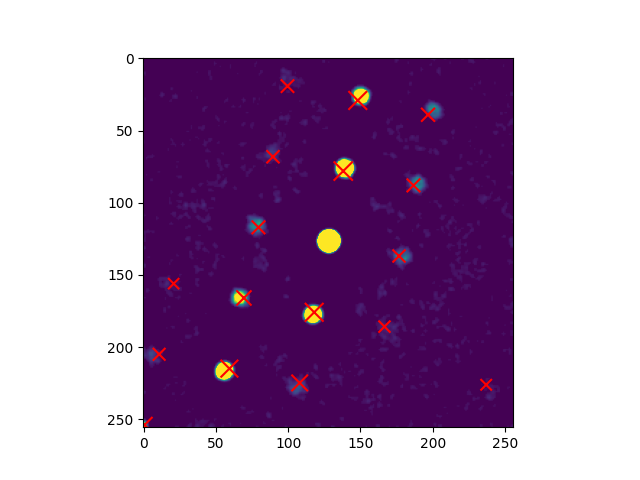

In [12]:
# signs will be 1 for the upper triangle, -1 for the lower triangle
mirrored = signs_n[0] == -1
x = putls.plot_template_over_pattern(image,
                                 simulations[indices_n[0]],
                                 in_plane_angle=angles_n[0],
                                 coordinate_system = "cartesian", 
                                 size_factor = 10,
                                 vmax=30, 
                                 max_r = 200,
                                 mirrored_template=mirrored,
                                 find_direct_beam=True,
                                 cmap = "viridis"
                                )

In [13]:
import diffpy
from diffsims.libraries.structure_library import StructureLibrary
from diffsims.generators.diffraction_generator import DiffractionGenerator
from diffsims.generators.library_generator import DiffractionLibraryGenerator
from pyxem.utils import indexation_utils as iutls
from pyxem.utils import plotting_utils as putls
from pyxem.utils import polar_transform_utils as ptutls
from pyxem.utils import expt_utils as eutls

In [14]:
%%capture burn
import diffpy
from diffsims.generators.rotation_list_generators import get_beam_directions_grid
from diffsims.generators.diffraction_generator import DiffractionGenerator
from diffsims.libraries.structure_library import StructureLibrary
from diffsims.generators.library_generator import DiffractionLibraryGenerator
from pyxem.utils.calibration_utils import find_diffraction_calibration

def template_log_func(x):
    return np.log10(x + 0.1)

resolution = 1 
grid = get_beam_directions_grid("cubic", resolution, mesh="spherified_cube_edge")
structure_matrix = diffpy.structure.loadStructure("Data/Au_mp-81_conventional_standard.cif")

diff_gen = DiffractionGenerator(accelerating_voltage=200,
                                precession_angle=1,
                                scattering_params=None,
                                shape_factor_model="linear",
                                minimum_intensity=0.1,
                                )

lib_gen = DiffractionLibraryGenerator(diff_gen)
library_phases = StructureLibrary(["phase"], [structure_matrix], [grid])

found_cal, corrline, found_cals = find_diffraction_calibration(test_patterns,0.0096,library_phases,lib_gen,20,
                                                               max_excitation_error= 0.08,
                                                               intensity_transform_function=template_log_func,
                                                               delta_r = 0.5,
                                                               max_r = np.sqrt(128**2+128**2) * 0.90
                                                              )

In [15]:
found_cal

0.009356032921810697

<IPython.core.display.Javascript object>


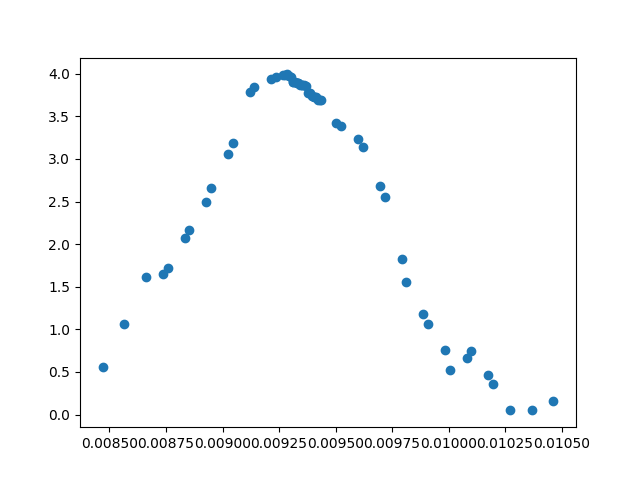

In [16]:
for i in range(1):
    x = corrline[1:,0,i]
    y = corrline[1:,1,i]
    fig1, ax1 = plt.subplots()
    plt.scatter(x,y)
    plt.show()

In [17]:
found_cals

array([0.00928459, 0.00930326, 0.009408  , 0.00914133, 0.00942933,
       0.00943393, 0.00943393, 0.00942933, 0.00934059])

In [18]:
diff_lib_au_optimized = lib_gen.get_diffraction_library(library_phases_au,
                                           calibration=found_cal,
                                           reciprocal_radius=reciprocal_radius,
                                           half_shape=half_shape,
                                           with_direct_beam=False,
                                           max_excitation_error=0.08)

In [19]:
simulations_optimized = diff_lib_au_optimized["au"]["simulations"]
image = test_patterns.data[1]

indices_n_opt, angles_n_opt, correlations_n_opt, signs_n_opt = iutls.get_n_best_matches(image,
                                                 simulations,
                                                 n_best,
                                                 frac_keep,
                                                 n_keep,
                                                 delta_r,
                                                 delta_theta,
                                                 max_r,
                                                 intensity_transform_function,
                                                 find_direct_beam,
                                                 direct_beam_position,
                                                 normalize_image,
                                                 normalize_templates,
                                                )

<IPython.core.display.Javascript object>


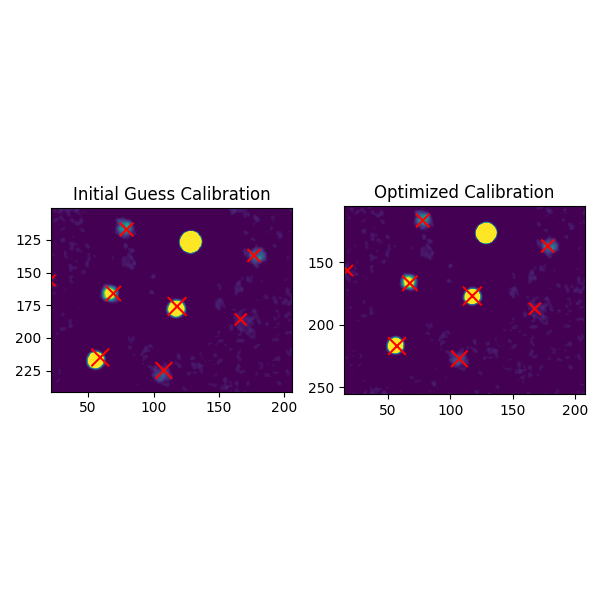

In [24]:
fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize = (6, 6))
mirrored = signs_n[0] == -1
ax[0].set_title("Initial Guess Calibration")
ax[0] = putls.plot_template_over_pattern(image,
                                 simulations[indices_n[0]],
                                 ax = ax[0],
                                 in_plane_angle=angles_n[0],
                                 coordinate_system = "cartesian", 
                                 size_factor = 10,
                                 vmax=30, 
                                 max_r = 200,
                                 mirrored_template=mirrored,
                                 find_direct_beam=True,
                                 cmap = "viridis"
                                )
mirrored = signs_n_opt[0] == -1
ax[1].set_title("Optimized Calibration")
ax[1] = putls.plot_template_over_pattern(image,
                                 simulations_optimized[indices_n_opt[0]],
                                 in_plane_angle=angles_n_opt[0],
                                 ax = ax[1],
                                 coordinate_system = "cartesian", 
                                 size_factor = 10,
                                 vmax=30, 
                                 max_r = 200,
                                 mirrored_template=mirrored,
                                 find_direct_beam=True,
                                 cmap = "viridis"
                                )
fig.tight_layout()

Following cells are for simulated patterns.

In [36]:
from pyxem.utils.plotting_utils import get_template_cartesian_coordinates 
from diffsims.pattern.detector_functions import add_shot_and_point_spread
import random

def pointplotter(simulations,inplane,template,sigma):
    pattern = hs.signals.Signal2D(np.zeros((256,256)))
    pattern.set_signal_type(signal_type="electron_diffraction")
    x, y, intensities = get_template_cartesian_coordinates(simulations[template],in_plane_angle=inplane,window_size=(255,255),center=(256//2,256//2))
    for i in range(x.size):
        pattern.isig[x[i],y[i]]=intensities[i]
    pattern = add_shot_and_point_spread(pattern.T, sigma, shot_noise=False)
    pattern = hs.signals.Signal2D(pattern)

    return pattern
def grab_random_pattern(simulations):
    inplane = random.randint(0,360)
    template = random.randint(0,simulations.size)
    pattern = pointplotter(simulations,inplane,template,5)
    return pattern, inplane, template
def build_random_tilts(diff_lib,n):
    orientations = diff_lib['orientations']
    simulations = diff_lib['simulations']
    pattern_set = hs.signals.Signal2D(np.zeros((n,1,256,256)))
    pattern_set.set_signal_type(signal_type="electron_diffraction")
    eulers = np.zeros((n,3))
    template_indexs = np.zeros((1,n))
    for i in range(n):
        pattern, inplane, template = grab_random_pattern(simulations)
        euler = orientations[template].copy()
        euler[0] = euler[0] + inplane
        pattern_set.inav[0,i] = pattern
        eulers[i,:] = euler
        template_indexs[0,i] = template
    return pattern_set,eulers,template_indexs

In [37]:
import diffpy
from diffsims.generators.rotation_list_generators import get_beam_directions_grid
from diffsims.generators.diffraction_generator import DiffractionGenerator
from diffsims.libraries.structure_library import StructureLibrary
from diffsims.generators.library_generator import DiffractionLibraryGenerator

diffraction_calibration = 0.01234

half_shape = (256//2, 256//2)

reciprocal_radius = np.sqrt(half_shape[0]**2 + half_shape[1]**2)*diffraction_calibration

resolution = 1 
grid = get_beam_directions_grid("cubic", resolution, mesh="spherified_cube_edge")
structure_matrix = diffpy.structure.loadStructure("Data/Au_mp-81_conventional_standard.cif")

diff_gen = DiffractionGenerator(accelerating_voltage=200,
                                precession_angle=1,
                                scattering_params=None,
                                shape_factor_model="linear",
                                minimum_intensity=0.1,
                                )

lib_gen = DiffractionLibraryGenerator(diff_gen)


library_phases_au = StructureLibrary(["au"], [structure_matrix], [grid])

diff_lib_au = lib_gen.get_diffraction_library(library_phases_au,
                                           calibration=diffraction_calibration,
                                           reciprocal_radius=reciprocal_radius,
                                           half_shape=half_shape,
                                           with_direct_beam=False,
                                           max_excitation_error=0.08)

/home/joseph/miniconda3/envs/pyxemmaster/lib/python3.9/site-packages/diffsims/generators/sphere_mesh_generators.py:515: RuntimeWarning: invalid value encountered in true_divide
  phi2 = sign * np.nan_to_num(np.arccos(x_comp / norm_proj))


In [38]:
data, eulers, template_indexs = build_random_tilts(diff_lib_au['au'],10)

In [39]:
data.plot()

In [40]:
%%capture burn
import diffpy
from diffsims.generators.rotation_list_generators import get_beam_directions_grid
from diffsims.generators.diffraction_generator import DiffractionGenerator
from diffsims.libraries.structure_library import StructureLibrary
from diffsims.generators.library_generator import DiffractionLibraryGenerator
from pyxem.utils.calibration_utils import find_diffraction_calibration

def template_log_func(x):
    return np.log10(x + 0.1)

resolution = 1 
grid = get_beam_directions_grid("cubic", resolution, mesh="spherified_cube_edge")
structure_matrix = diffpy.structure.loadStructure("Data/Au_mp-81_conventional_standard.cif")

diff_gen = DiffractionGenerator(accelerating_voltage=200,
                                precession_angle=1,
                                scattering_params=None,
                                shape_factor_model="linear",
                                minimum_intensity=0.1,
                                )

lib_gen = DiffractionLibraryGenerator(diff_gen)
library_phases = StructureLibrary(["phase"], [structure_matrix], [grid])

found_cal, corrline, found_cals = find_diffraction_calibration(data,0.011,library_phases,lib_gen,20,
                                                               max_excitation_error= 0.08,
                                                               intensity_transform_function=template_log_func,
                                                               delta_r = 0.5,
                                                               max_r = np.sqrt(128**2+128**2) * 0.90
                                                              )

In [41]:
found_cal

0.012308010000000008